In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                        | 0/60000 [00:00<?, ?it/s]

 11%|█████████▌                                                                                | 6339/60000 [00:00<00:00, 63381.60it/s]

 22%|███████████████████▍                                                                     | 13134/60000 [00:00<00:00, 66063.41it/s]

 33%|█████████████████████████████▌                                                           | 19964/60000 [00:00<00:00, 67082.74it/s]

 45%|███████████████████████████████████████▊                                                 | 26827/60000 [00:00<00:00, 67690.77it/s]

 56%|█████████████████████████████████████████████████▊                                       | 33607/60000 [00:00<00:00, 67726.28it/s]

 67%|███████████████████████████████████████████████████████████▉                             | 40421/60000 [00:00<00:00, 67865.74it/s]

 79%|██████████████████████████████████████████████████████████████████████                   | 47263/60000 [00:00<00:00, 68044.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▎        | 54112/60000 [00:00<00:00, 68185.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 67582.48it/s]

  0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 6884/10000 [00:00<00:00, 68829.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 67764.83it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

0:1:2:3:4 59ftut3f


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                          | 0/368 [00:00<?, ?it/s]

  0%|▎                                                                                                 | 1/368 [00:00<04:46,  1.28it/s]

  1%|█                                                                                                 | 4/368 [00:00<01:04,  5.64it/s]

  2%|██▏                                                                                               | 8/368 [00:01<00:31, 11.43it/s]

  3%|███▏                                                                                             | 12/368 [00:01<00:21, 16.64it/s]

  4%|████▏                                                                                            | 16/368 [00:01<00:16, 21.11it/s]

  5%|█████▎                                                                                           | 20/368 [00:01<00:14, 24.70it/s]

  7%|██████▎                                                                                          | 24/368 [00:01<00:12, 27.49it/s]

  8%|███████▍                                                                                         | 28/368 [00:01<00:11, 29.61it/s]

  9%|████████▍                                                                                        | 32/368 [00:01<00:10, 31.20it/s]

 10%|█████████▍                                                                                       | 36/368 [00:01<00:10, 32.35it/s]

 11%|██████████▌                                                                                      | 40/368 [00:01<00:09, 33.19it/s]

 12%|███████████▌                                                                                     | 44/368 [00:02<00:09, 33.74it/s]

 13%|████████████▋                                                                                    | 48/368 [00:02<00:09, 34.19it/s]

 14%|█████████████▋                                                                                   | 52/368 [00:02<00:09, 34.52it/s]

 15%|██████████████▊                                                                                  | 56/368 [00:02<00:08, 34.67it/s]

 16%|███████████████▊                                                                                 | 60/368 [00:02<00:08, 34.84it/s]

 17%|████████████████▊                                                                                | 64/368 [00:02<00:08, 34.91it/s]

 18%|█████████████████▉                                                                               | 68/368 [00:02<00:08, 35.04it/s]

 20%|██████████████████▉                                                                              | 72/368 [00:02<00:08, 35.10it/s]

 21%|████████████████████                                                                             | 76/368 [00:02<00:08, 35.12it/s]

 22%|█████████████████████                                                                            | 80/368 [00:03<00:08, 35.06it/s]

 23%|██████████████████████▏                                                                          | 84/368 [00:03<00:08, 34.98it/s]

 24%|███████████████████████▏                                                                         | 88/368 [00:03<00:08, 34.91it/s]

 25%|████████████████████████▎                                                                        | 92/368 [00:03<00:07, 35.03it/s]

 26%|█████████████████████████▎                                                                       | 96/368 [00:03<00:07, 34.72it/s]

 27%|██████████████████████████                                                                      | 100/368 [00:03<00:07, 34.72it/s]

 28%|███████████████████████████▏                                                                    | 104/368 [00:03<00:07, 34.82it/s]

 29%|████████████████████████████▏                                                                   | 108/368 [00:03<00:07, 34.97it/s]

 30%|█████████████████████████████▏                                                                  | 112/368 [00:03<00:07, 35.05it/s]

 32%|██████████████████████████████▎                                                                 | 116/368 [00:04<00:07, 35.12it/s]

 33%|███████████████████████████████▎                                                                | 120/368 [00:04<00:07, 35.04it/s]

 34%|████████████████████████████████▎                                                               | 124/368 [00:04<00:06, 35.05it/s]

 35%|█████████████████████████████████▍                                                              | 128/368 [00:04<00:06, 35.12it/s]

 36%|██████████████████████████████████▍                                                             | 132/368 [00:04<00:06, 35.12it/s]

 37%|███████████████████████████████████▍                                                            | 136/368 [00:04<00:06, 35.07it/s]

 38%|████████████████████████████████████▌                                                           | 140/368 [00:04<00:06, 35.14it/s]

 39%|█████████████████████████████████████▌                                                          | 144/368 [00:04<00:06, 35.14it/s]

 40%|██████████████████████████████████████▌                                                         | 148/368 [00:04<00:06, 35.04it/s]

 41%|███████████████████████████████████████▋                                                        | 152/368 [00:05<00:06, 34.99it/s]

 42%|████████████████████████████████████████▋                                                       | 156/368 [00:05<00:06, 34.88it/s]

 43%|█████████████████████████████████████████▋                                                      | 160/368 [00:05<00:05, 34.90it/s]

 45%|██████████████████████████████████████████▊                                                     | 164/368 [00:05<00:05, 34.88it/s]

 46%|███████████████████████████████████████████▊                                                    | 168/368 [00:05<00:05, 34.85it/s]

 47%|████████████████████████████████████████████▊                                                   | 172/368 [00:05<00:05, 34.86it/s]

 48%|█████████████████████████████████████████████▉                                                  | 176/368 [00:05<00:05, 35.00it/s]

 49%|██████████████████████████████████████████████▉                                                 | 180/368 [00:05<00:05, 34.99it/s]

 50%|████████████████████████████████████████████████                                                | 184/368 [00:06<00:05, 35.02it/s]

 51%|█████████████████████████████████████████████████                                               | 188/368 [00:06<00:05, 35.09it/s]

 52%|██████████████████████████████████████████████████                                              | 192/368 [00:06<00:05, 35.13it/s]

 53%|███████████████████████████████████████████████████▏                                            | 196/368 [00:06<00:04, 34.89it/s]

 54%|████████████████████████████████████████████████████▏                                           | 200/368 [00:06<00:04, 34.94it/s]

 55%|█████████████████████████████████████████████████████▏                                          | 204/368 [00:06<00:04, 34.99it/s]

 57%|██████████████████████████████████████████████████████▎                                         | 208/368 [00:06<00:04, 35.02it/s]

 58%|███████████████████████████████████████████████████████▎                                        | 212/368 [00:06<00:04, 35.03it/s]

 59%|████████████████████████████████████████████████████████▎                                       | 216/368 [00:06<00:04, 35.00it/s]

 60%|█████████████████████████████████████████████████████████▍                                      | 220/368 [00:07<00:04, 34.91it/s]

 61%|██████████████████████████████████████████████████████████▍                                     | 224/368 [00:07<00:04, 34.88it/s]

 62%|███████████████████████████████████████████████████████████▍                                    | 228/368 [00:07<00:04, 34.80it/s]

 63%|████████████████████████████████████████████████████████████▌                                   | 232/368 [00:07<00:03, 34.78it/s]

 64%|█████████████████████████████████████████████████████████████▌                                  | 236/368 [00:07<00:03, 34.77it/s]

 65%|██████████████████████████████████████████████████████████████▌                                 | 240/368 [00:07<00:03, 34.84it/s]

 66%|███████████████████████████████████████████████████████████████▋                                | 244/368 [00:07<00:03, 34.91it/s]

 67%|████████████████████████████████████████████████████████████████▋                               | 248/368 [00:07<00:03, 34.96it/s]

 68%|█████████████████████████████████████████████████████████████████▋                              | 252/368 [00:07<00:03, 34.97it/s]

 70%|██████████████████████████████████████████████████████████████████▊                             | 256/368 [00:08<00:03, 35.01it/s]

 71%|███████████████████████████████████████████████████████████████████▊                            | 260/368 [00:08<00:03, 35.09it/s]

 72%|████████████████████████████████████████████████████████████████████▊                           | 264/368 [00:08<00:02, 35.10it/s]

 73%|█████████████████████████████████████████████████████████████████████▉                          | 268/368 [00:08<00:02, 35.12it/s]

 74%|██████████████████████████████████████████████████████████████████████▉                         | 272/368 [00:08<00:02, 35.14it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 276/368 [00:08<00:02, 35.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████                       | 280/368 [00:08<00:02, 35.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████                      | 284/368 [00:08<00:02, 35.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████▏                    | 288/368 [00:08<00:02, 35.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████▏                   | 292/368 [00:09<00:02, 35.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▏                  | 296/368 [00:09<00:02, 35.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 300/368 [00:09<00:01, 35.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▎                | 304/368 [00:09<00:01, 34.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▎               | 308/368 [00:09<00:01, 34.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▍              | 312/368 [00:09<00:01, 34.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▍             | 316/368 [00:09<00:01, 34.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▍            | 320/368 [00:09<00:01, 34.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▌           | 324/368 [00:10<00:01, 34.95it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▌          | 328/368 [00:10<00:01, 35.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▌         | 332/368 [00:10<00:01, 35.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▋        | 336/368 [00:10<00:00, 35.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▋       | 340/368 [00:10<00:00, 35.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▋      | 344/368 [00:10<00:00, 35.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▊     | 348/368 [00:10<00:00, 35.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▊    | 352/368 [00:10<00:00, 35.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▊   | 356/368 [00:10<00:00, 34.94it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▉  | 360/368 [00:11<00:00, 34.73it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 364/368 [00:11<00:00, 35.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:11<00:00, 31.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:11<00:00, 32.37it/s]

train - OK


  0%|                                                                                                           | 0/92 [00:00<?, ?it/s]

  1%|█                                                                                                  | 1/92 [00:00<00:13,  6.67it/s]

  5%|█████▍                                                                                             | 5/92 [00:00<00:04, 20.97it/s]

 10%|█████████▋                                                                                         | 9/92 [00:00<00:03, 26.63it/s]

 14%|█████████████▊                                                                                    | 13/92 [00:00<00:02, 29.63it/s]

 18%|██████████████████                                                                                | 17/92 [00:00<00:02, 31.41it/s]

 23%|██████████████████████▎                                                                           | 21/92 [00:00<00:02, 32.42it/s]

 27%|██████████████████████████▋                                                                       | 25/92 [00:00<00:02, 33.14it/s]

 32%|██████████████████████████████▉                                                                   | 29/92 [00:00<00:01, 33.59it/s]

 36%|███████████████████████████████████▏                                                              | 33/92 [00:01<00:01, 33.91it/s]

 40%|███████████████████████████████████████▍                                                          | 37/92 [00:01<00:01, 34.13it/s]

 45%|███████████████████████████████████████████▋                                                      | 41/92 [00:01<00:01, 34.07it/s]

 49%|███████████████████████████████████████████████▉                                                  | 45/92 [00:01<00:01, 34.21it/s]

 53%|████████████████████████████████████████████████████▏                                             | 49/92 [00:01<00:01, 34.29it/s]

 58%|████████████████████████████████████████████████████████▍                                         | 53/92 [00:01<00:01, 34.34it/s]

 62%|████████████████████████████████████████████████████████████▋                                     | 57/92 [00:01<00:01, 34.42it/s]

 66%|████████████████████████████████████████████████████████████████▉                                 | 61/92 [00:01<00:00, 34.46it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 65/92 [00:02<00:00, 34.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 69/92 [00:02<00:00, 34.45it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 73/92 [00:02<00:00, 34.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 77/92 [00:02<00:00, 34.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 81/92 [00:02<00:00, 34.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 85/92 [00:02<00:00, 34.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 89/92 [00:02<00:00, 35.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 32.56it/s]

val - OK


  0%|                                                                                                           | 0/76 [00:00<?, ?it/s]

  1%|█▎                                                                                                 | 1/76 [00:00<00:10,  7.00it/s]

  7%|██████▌                                                                                            | 5/76 [00:00<00:03, 21.48it/s]

 12%|███████████▋                                                                                       | 9/76 [00:00<00:02, 27.21it/s]

 17%|████████████████▊                                                                                 | 13/76 [00:00<00:02, 29.95it/s]

 22%|█████████████████████▉                                                                            | 17/76 [00:00<00:01, 31.58it/s]

 28%|███████████████████████████                                                                       | 21/76 [00:00<00:01, 32.55it/s]

 33%|████████████████████████████████▏                                                                 | 25/76 [00:00<00:01, 33.16it/s]

 38%|█████████████████████████████████████▍                                                            | 29/76 [00:00<00:01, 33.60it/s]

 43%|██████████████████████████████████████████▌                                                       | 33/76 [00:01<00:01, 33.88it/s]

 49%|███████████████████████████████████████████████▋                                                  | 37/76 [00:01<00:01, 34.11it/s]

 54%|████████████████████████████████████████████████████▊                                             | 41/76 [00:01<00:01, 34.20it/s]

 59%|██████████████████████████████████████████████████████████                                        | 45/76 [00:01<00:00, 34.17it/s]

 64%|███████████████████████████████████████████████████████████████▏                                  | 49/76 [00:01<00:00, 34.25it/s]

 70%|████████████████████████████████████████████████████████████████████▎                             | 53/76 [00:01<00:00, 34.20it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 57/76 [00:01<00:00, 34.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 61/76 [00:01<00:00, 34.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 65/76 [00:02<00:00, 34.36it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 69/76 [00:02<00:00, 34.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 73/76 [00:02<00:00, 35.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 32.21it/s]

test InD - OK


  0%|                                                                                                          | 0/559 [00:00<?, ?it/s]

  0%|▏                                                                                                 | 1/559 [00:00<01:20,  6.92it/s]

  1%|▉                                                                                                 | 5/559 [00:00<00:25, 21.36it/s]

  2%|█▌                                                                                                | 9/559 [00:00<00:20, 27.05it/s]

  2%|██▎                                                                                              | 13/559 [00:00<00:18, 29.88it/s]

  3%|██▉                                                                                              | 17/559 [00:00<00:17, 31.47it/s]

  4%|███▋                                                                                             | 21/559 [00:00<00:16, 32.46it/s]

  4%|████▎                                                                                            | 25/559 [00:00<00:16, 32.99it/s]

  5%|█████                                                                                            | 29/559 [00:00<00:15, 33.43it/s]

  6%|█████▋                                                                                           | 33/559 [00:01<00:15, 33.61it/s]

  7%|██████▍                                                                                          | 37/559 [00:01<00:15, 33.88it/s]

  7%|███████                                                                                          | 41/559 [00:01<00:15, 33.98it/s]

  8%|███████▊                                                                                         | 45/559 [00:01<00:15, 34.11it/s]

  9%|████████▌                                                                                        | 49/559 [00:01<00:14, 34.14it/s]

  9%|█████████▏                                                                                       | 53/559 [00:01<00:14, 34.18it/s]

 10%|█████████▉                                                                                       | 57/559 [00:01<00:14, 34.16it/s]

 11%|██████████▌                                                                                      | 61/559 [00:01<00:14, 34.14it/s]

 12%|███████████▎                                                                                     | 65/559 [00:02<00:14, 34.27it/s]

 12%|███████████▉                                                                                     | 69/559 [00:02<00:14, 34.32it/s]

 13%|████████████▋                                                                                    | 73/559 [00:02<00:14, 34.33it/s]

 14%|█████████████▎                                                                                   | 77/559 [00:02<00:14, 34.33it/s]

 14%|██████████████                                                                                   | 81/559 [00:02<00:13, 34.33it/s]

 15%|██████████████▋                                                                                  | 85/559 [00:02<00:13, 34.41it/s]

 16%|███████████████▍                                                                                 | 89/559 [00:02<00:13, 34.36it/s]

 17%|████████████████▏                                                                                | 93/559 [00:02<00:13, 34.31it/s]

 17%|████████████████▊                                                                                | 97/559 [00:02<00:13, 34.11it/s]

 18%|█████████████████▎                                                                              | 101/559 [00:03<00:13, 34.20it/s]

 19%|██████████████████                                                                              | 105/559 [00:03<00:13, 34.26it/s]

 19%|██████████████████▋                                                                             | 109/559 [00:03<00:13, 34.30it/s]

 20%|███████████████████▍                                                                            | 113/559 [00:03<00:12, 34.32it/s]

 21%|████████████████████                                                                            | 117/559 [00:03<00:12, 34.27it/s]

 22%|████████████████████▊                                                                           | 121/559 [00:03<00:12, 34.29it/s]

 22%|█████████████████████▍                                                                          | 125/559 [00:03<00:12, 34.31it/s]

 23%|██████████████████████▏                                                                         | 129/559 [00:03<00:12, 34.30it/s]

 24%|██████████████████████▊                                                                         | 133/559 [00:03<00:12, 34.29it/s]

 25%|███████████████████████▌                                                                        | 137/559 [00:04<00:12, 34.30it/s]

 25%|████████████████████████▏                                                                       | 141/559 [00:04<00:12, 34.27it/s]

 26%|████████████████████████▉                                                                       | 145/559 [00:04<00:12, 34.39it/s]

 27%|█████████████████████████▌                                                                      | 149/559 [00:04<00:11, 34.43it/s]

 27%|██████████████████████████▎                                                                     | 153/559 [00:04<00:11, 34.38it/s]

 28%|██████████████████████████▉                                                                     | 157/559 [00:04<00:11, 34.32it/s]

 29%|███████████████████████████▋                                                                    | 161/559 [00:04<00:11, 34.27it/s]

 30%|████████████████████████████▎                                                                   | 165/559 [00:04<00:11, 34.26it/s]

 30%|█████████████████████████████                                                                   | 169/559 [00:05<00:11, 34.31it/s]

 31%|█████████████████████████████▋                                                                  | 173/559 [00:05<00:11, 34.36it/s]

 32%|██████████████████████████████▍                                                                 | 177/559 [00:05<00:11, 34.33it/s]

 32%|███████████████████████████████                                                                 | 181/559 [00:05<00:11, 34.31it/s]

 33%|███████████████████████████████▊                                                                | 185/559 [00:05<00:10, 34.36it/s]

 34%|████████████████████████████████▍                                                               | 189/559 [00:05<00:10, 34.35it/s]

 35%|█████████████████████████████████▏                                                              | 193/559 [00:05<00:10, 34.35it/s]

 35%|█████████████████████████████████▊                                                              | 197/559 [00:05<00:10, 34.31it/s]

 36%|██████████████████████████████████▌                                                             | 201/559 [00:05<00:10, 34.39it/s]

 37%|███████████████████████████████████▏                                                            | 205/559 [00:06<00:10, 34.39it/s]

 37%|███████████████████████████████████▉                                                            | 209/559 [00:06<00:10, 34.40it/s]

 38%|████████████████████████████████████▌                                                           | 213/559 [00:06<00:10, 34.40it/s]

 39%|█████████████████████████████████████▎                                                          | 217/559 [00:06<00:09, 34.41it/s]

 40%|█████████████████████████████████████▉                                                          | 221/559 [00:06<00:09, 34.36it/s]

 40%|██████████████████████████████████████▋                                                         | 225/559 [00:06<00:09, 34.11it/s]

 41%|███████████████████████████████████████▎                                                        | 229/559 [00:06<00:09, 34.23it/s]

 42%|████████████████████████████████████████                                                        | 233/559 [00:06<00:09, 34.31it/s]

 42%|████████████████████████████████████████▋                                                       | 237/559 [00:07<00:09, 34.29it/s]

 43%|█████████████████████████████████████████▍                                                      | 241/559 [00:07<00:09, 34.35it/s]

 44%|██████████████████████████████████████████                                                      | 245/559 [00:07<00:09, 34.39it/s]

 45%|██████████████████████████████████████████▊                                                     | 249/559 [00:07<00:09, 34.33it/s]

 45%|███████████████████████████████████████████▍                                                    | 253/559 [00:07<00:08, 34.33it/s]

 46%|████████████████████████████████████████████▏                                                   | 257/559 [00:07<00:08, 34.31it/s]

 47%|████████████████████████████████████████████▊                                                   | 261/559 [00:07<00:08, 34.26it/s]

 47%|█████████████████████████████████████████████▌                                                  | 265/559 [00:07<00:08, 34.22it/s]

 48%|██████████████████████████████████████████████▏                                                 | 269/559 [00:07<00:08, 34.22it/s]

 49%|██████████████████████████████████████████████▉                                                 | 273/559 [00:08<00:08, 34.32it/s]

 50%|███████████████████████████████████████████████▌                                                | 277/559 [00:08<00:08, 34.33it/s]

 50%|████████████████████████████████████████████████▎                                               | 281/559 [00:08<00:08, 34.28it/s]

 51%|████████████████████████████████████████████████▉                                               | 285/559 [00:08<00:07, 34.28it/s]

 52%|█████████████████████████████████████████████████▋                                              | 289/559 [00:08<00:07, 34.21it/s]

 52%|██████████████████████████████████████████████████▎                                             | 293/559 [00:08<00:07, 34.29it/s]

 53%|███████████████████████████████████████████████████                                             | 297/559 [00:08<00:07, 34.25it/s]

 54%|███████████████████████████████████████████████████▋                                            | 301/559 [00:08<00:07, 34.24it/s]

 55%|████████████████████████████████████████████████████▍                                           | 305/559 [00:09<00:07, 34.18it/s]

 55%|█████████████████████████████████████████████████████                                           | 309/559 [00:09<00:07, 34.19it/s]

 56%|█████████████████████████████████████████████████████▊                                          | 313/559 [00:09<00:07, 34.26it/s]

 57%|██████████████████████████████████████████████████████▍                                         | 317/559 [00:09<00:07, 34.21it/s]

 57%|███████████████████████████████████████████████████████▏                                        | 321/559 [00:09<00:06, 34.20it/s]

 58%|███████████████████████████████████████████████████████▊                                        | 325/559 [00:09<00:06, 34.18it/s]

 59%|████████████████████████████████████████████████████████▌                                       | 329/559 [00:09<00:06, 34.23it/s]

 60%|█████████████████████████████████████████████████████████▏                                      | 333/559 [00:09<00:06, 34.19it/s]

 60%|█████████████████████████████████████████████████████████▊                                      | 337/559 [00:09<00:06, 34.17it/s]

 61%|██████████████████████████████████████████████████████████▌                                     | 341/559 [00:10<00:06, 34.25it/s]

 62%|███████████████████████████████████████████████████████████▏                                    | 345/559 [00:10<00:06, 34.22it/s]

 62%|███████████████████████████████████████████████████████████▉                                    | 349/559 [00:10<00:06, 33.84it/s]

 63%|████████████████████████████████████████████████████████████▌                                   | 353/559 [00:10<00:06, 33.89it/s]

 64%|█████████████████████████████████████████████████████████████▎                                  | 357/559 [00:10<00:05, 33.86it/s]

 65%|█████████████████████████████████████████████████████████████▉                                  | 361/559 [00:10<00:05, 33.97it/s]

 65%|██████████████████████████████████████████████████████████████▋                                 | 365/559 [00:10<00:05, 34.05it/s]

 66%|███████████████████████████████████████████████████████████████▎                                | 369/559 [00:10<00:05, 34.04it/s]

 67%|████████████████████████████████████████████████████████████████                                | 373/559 [00:11<00:05, 34.08it/s]

 67%|████████████████████████████████████████████████████████████████▋                               | 377/559 [00:11<00:05, 34.12it/s]

 68%|█████████████████████████████████████████████████████████████████▍                              | 381/559 [00:11<00:05, 34.13it/s]

 69%|██████████████████████████████████████████████████████████████████                              | 385/559 [00:11<00:05, 34.13it/s]

 70%|██████████████████████████████████████████████████████████████████▊                             | 389/559 [00:11<00:04, 34.11it/s]

 70%|███████████████████████████████████████████████████████████████████▍                            | 393/559 [00:11<00:04, 34.13it/s]

 71%|████████████████████████████████████████████████████████████████████▏                           | 397/559 [00:11<00:04, 34.22it/s]

 72%|████████████████████████████████████████████████████████████████████▊                           | 401/559 [00:11<00:04, 34.15it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                          | 405/559 [00:11<00:04, 34.14it/s]

 73%|██████████████████████████████████████████████████████████████████████▏                         | 409/559 [00:12<00:04, 34.21it/s]

 74%|██████████████████████████████████████████████████████████████████████▉                         | 413/559 [00:12<00:04, 34.21it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                        | 417/559 [00:12<00:04, 34.17it/s]

 75%|████████████████████████████████████████████████████████████████████████▎                       | 421/559 [00:12<00:04, 34.11it/s]

 76%|████████████████████████████████████████████████████████████████████████▉                       | 425/559 [00:12<00:03, 34.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████▋                      | 429/559 [00:12<00:03, 34.10it/s]

 77%|██████████████████████████████████████████████████████████████████████████▎                     | 433/559 [00:12<00:03, 34.05it/s]

 78%|███████████████████████████████████████████████████████████████████████████                     | 437/559 [00:12<00:03, 34.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████▋                    | 441/559 [00:12<00:03, 34.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████▍                   | 445/559 [00:13<00:03, 34.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████                   | 449/559 [00:13<00:03, 34.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 453/559 [00:13<00:03, 34.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▍                 | 457/559 [00:13<00:02, 34.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▏                | 461/559 [00:13<00:02, 34.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▊                | 465/559 [00:13<00:02, 34.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▌               | 469/559 [00:13<00:02, 34.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▏              | 473/559 [00:13<00:02, 33.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▉              | 477/559 [00:14<00:02, 33.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▌             | 481/559 [00:14<00:02, 33.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▎            | 485/559 [00:14<00:02, 34.03it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▉            | 489/559 [00:14<00:02, 34.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 493/559 [00:14<00:01, 34.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 497/559 [00:14<00:01, 34.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████          | 501/559 [00:14<00:01, 34.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 505/559 [00:14<00:01, 34.15it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▍        | 509/559 [00:14<00:01, 34.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████        | 513/559 [00:15<00:01, 34.12it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▊       | 517/559 [00:15<00:01, 34.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▍      | 521/559 [00:15<00:01, 34.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▏     | 525/559 [00:15<00:00, 34.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▊     | 529/559 [00:15<00:00, 34.16it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▌    | 533/559 [00:15<00:00, 34.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 537/559 [00:15<00:00, 34.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▉   | 541/559 [00:15<00:00, 34.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▌  | 545/559 [00:16<00:00, 34.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 549/559 [00:16<00:00, 34.23it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 553/559 [00:16<00:00, 34.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 557/559 [00:16<00:00, 35.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:16<00:00, 33.90it/s]

test OoD - OK


  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                              | 4/100 [00:00<00:02, 37.84it/s]

  8%|███████▊                                                                                          | 8/100 [00:00<00:02, 38.18it/s]

 12%|███████████▋                                                                                     | 12/100 [00:00<00:02, 38.45it/s]

 16%|███████████████▌                                                                                 | 16/100 [00:00<00:02, 38.51it/s]

 20%|███████████████████▍                                                                             | 20/100 [00:00<00:02, 38.09it/s]

 24%|███████████████████████▎                                                                         | 24/100 [00:00<00:02, 37.97it/s]

 28%|███████████████████████████▏                                                                     | 28/100 [00:00<00:01, 37.81it/s]

 32%|███████████████████████████████                                                                  | 32/100 [00:00<00:01, 37.71it/s]

 36%|██████████████████████████████████▉                                                              | 36/100 [00:00<00:01, 37.70it/s]

 40%|██████████████████████████████████████▊                                                          | 40/100 [00:01<00:01, 37.60it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:01<00:01, 36.96it/s]

 48%|██████████████████████████████████████████████▌                                                  | 48/100 [00:01<00:01, 36.79it/s]

 52%|██████████████████████████████████████████████████▍                                              | 52/100 [00:01<00:01, 37.42it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 56/100 [00:01<00:01, 37.93it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 60/100 [00:01<00:01, 38.38it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 64/100 [00:01<00:00, 38.25it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 68/100 [00:01<00:00, 38.54it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 72/100 [00:01<00:00, 38.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 76/100 [00:01<00:00, 38.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 80/100 [00:02<00:00, 39.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 84/100 [00:02<00:00, 39.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 88/100 [00:02<00:00, 39.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:02<00:00, 39.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:02<00:00, 38.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.28it/s]

test RnD - OK
(23523,) (23523,)
(5881,) (5881,)
(4861,) (4861,)
(35735,) (35735,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

8.422156 0.53417563
8.403616 0.5132675
8.449216 0.5189558
8.4944725 0.6260531
17.990528 1.0678421
13.962212 0.015789311
13.962387 0.01638552
13.96209 0.016721057
13.959389 0.018434748
29.563755 0.66191936


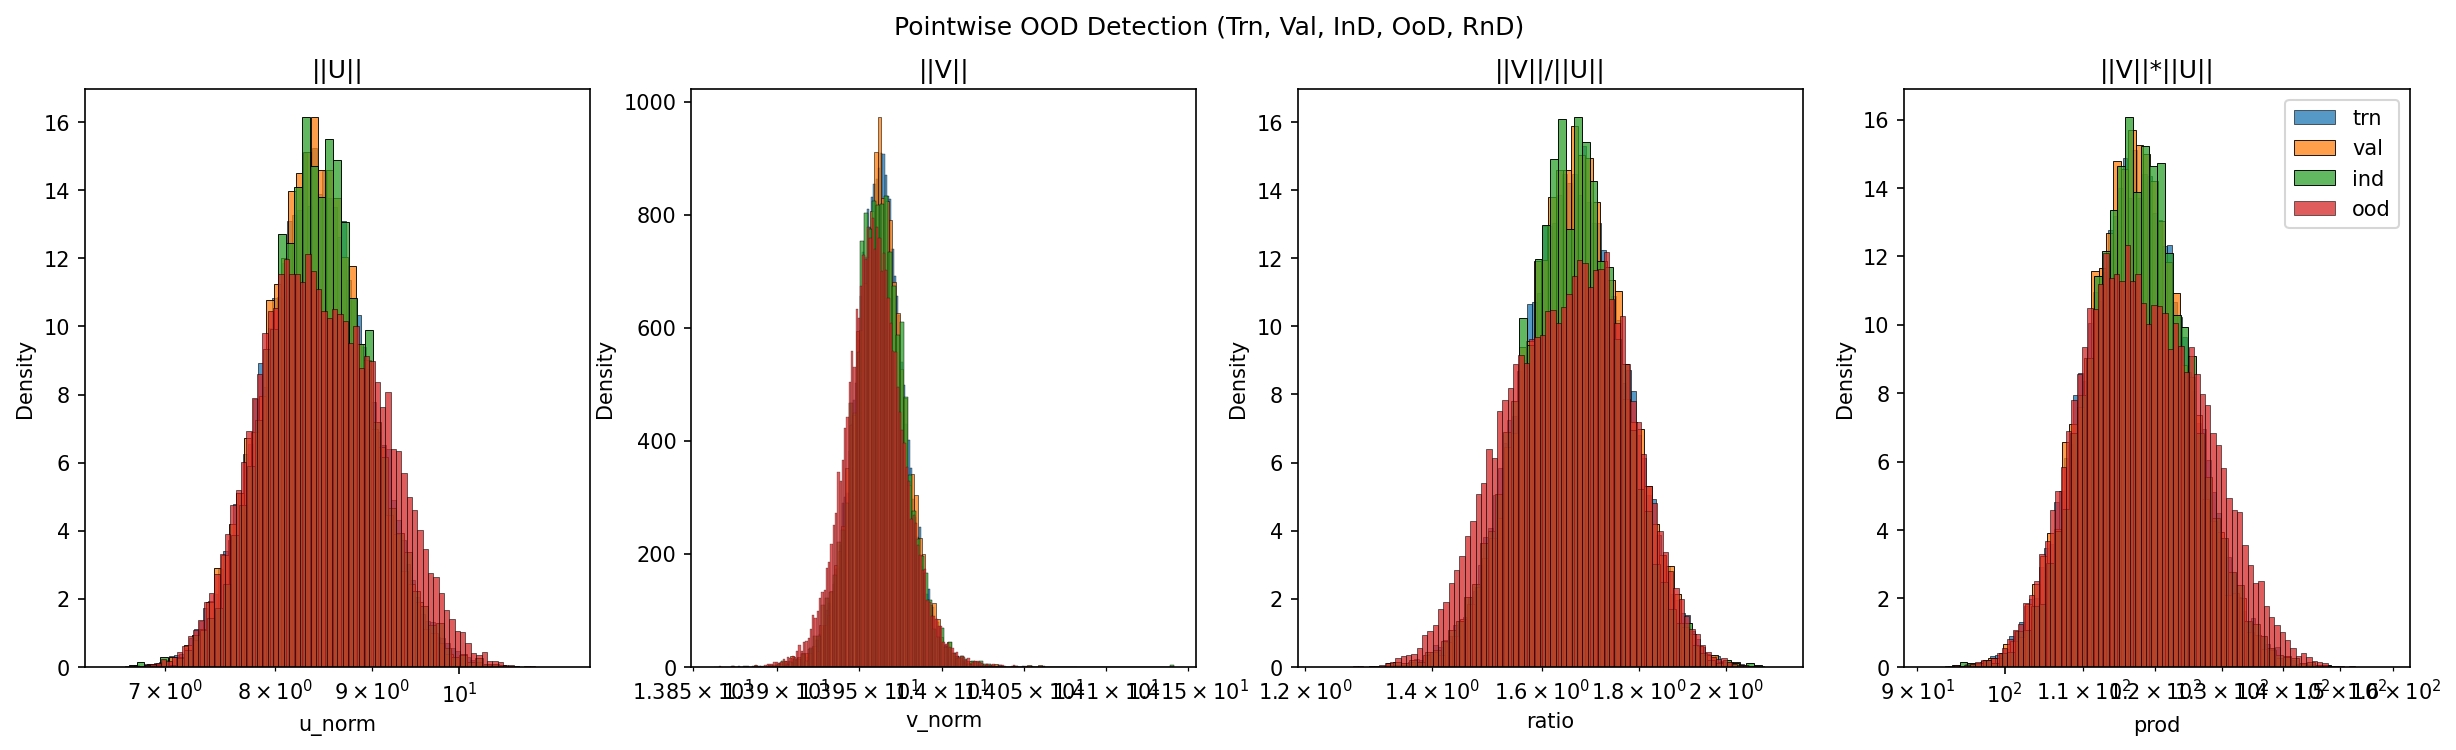

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 13.872835 14.062442 0.18960667
Val 13.886201 14.060711 0.17451
Ind 13.898033 14.141129 0.2430954
Ood 13.862375 14.08207 0.21969509
Rnd 26.971115 32.35933 5.388214
KstestResult(statistic=0.08302659462654638, pvalue=4.1512526581170164e-26, statistic_location=13.950412, statistic_sign=-1)


[2, 4, 0, 1, 3, 5, 9, 6, 7, 8]


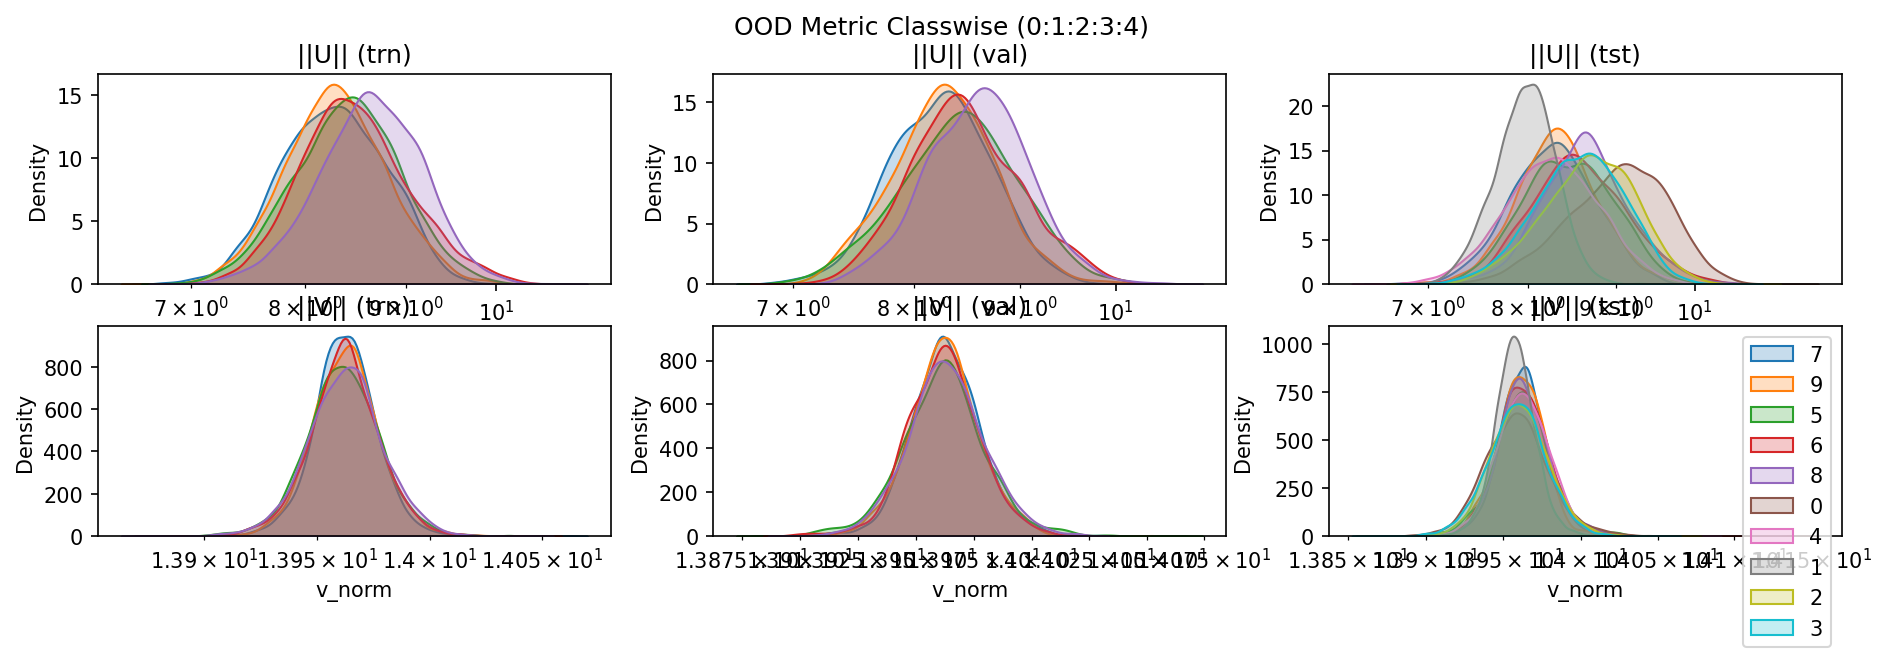

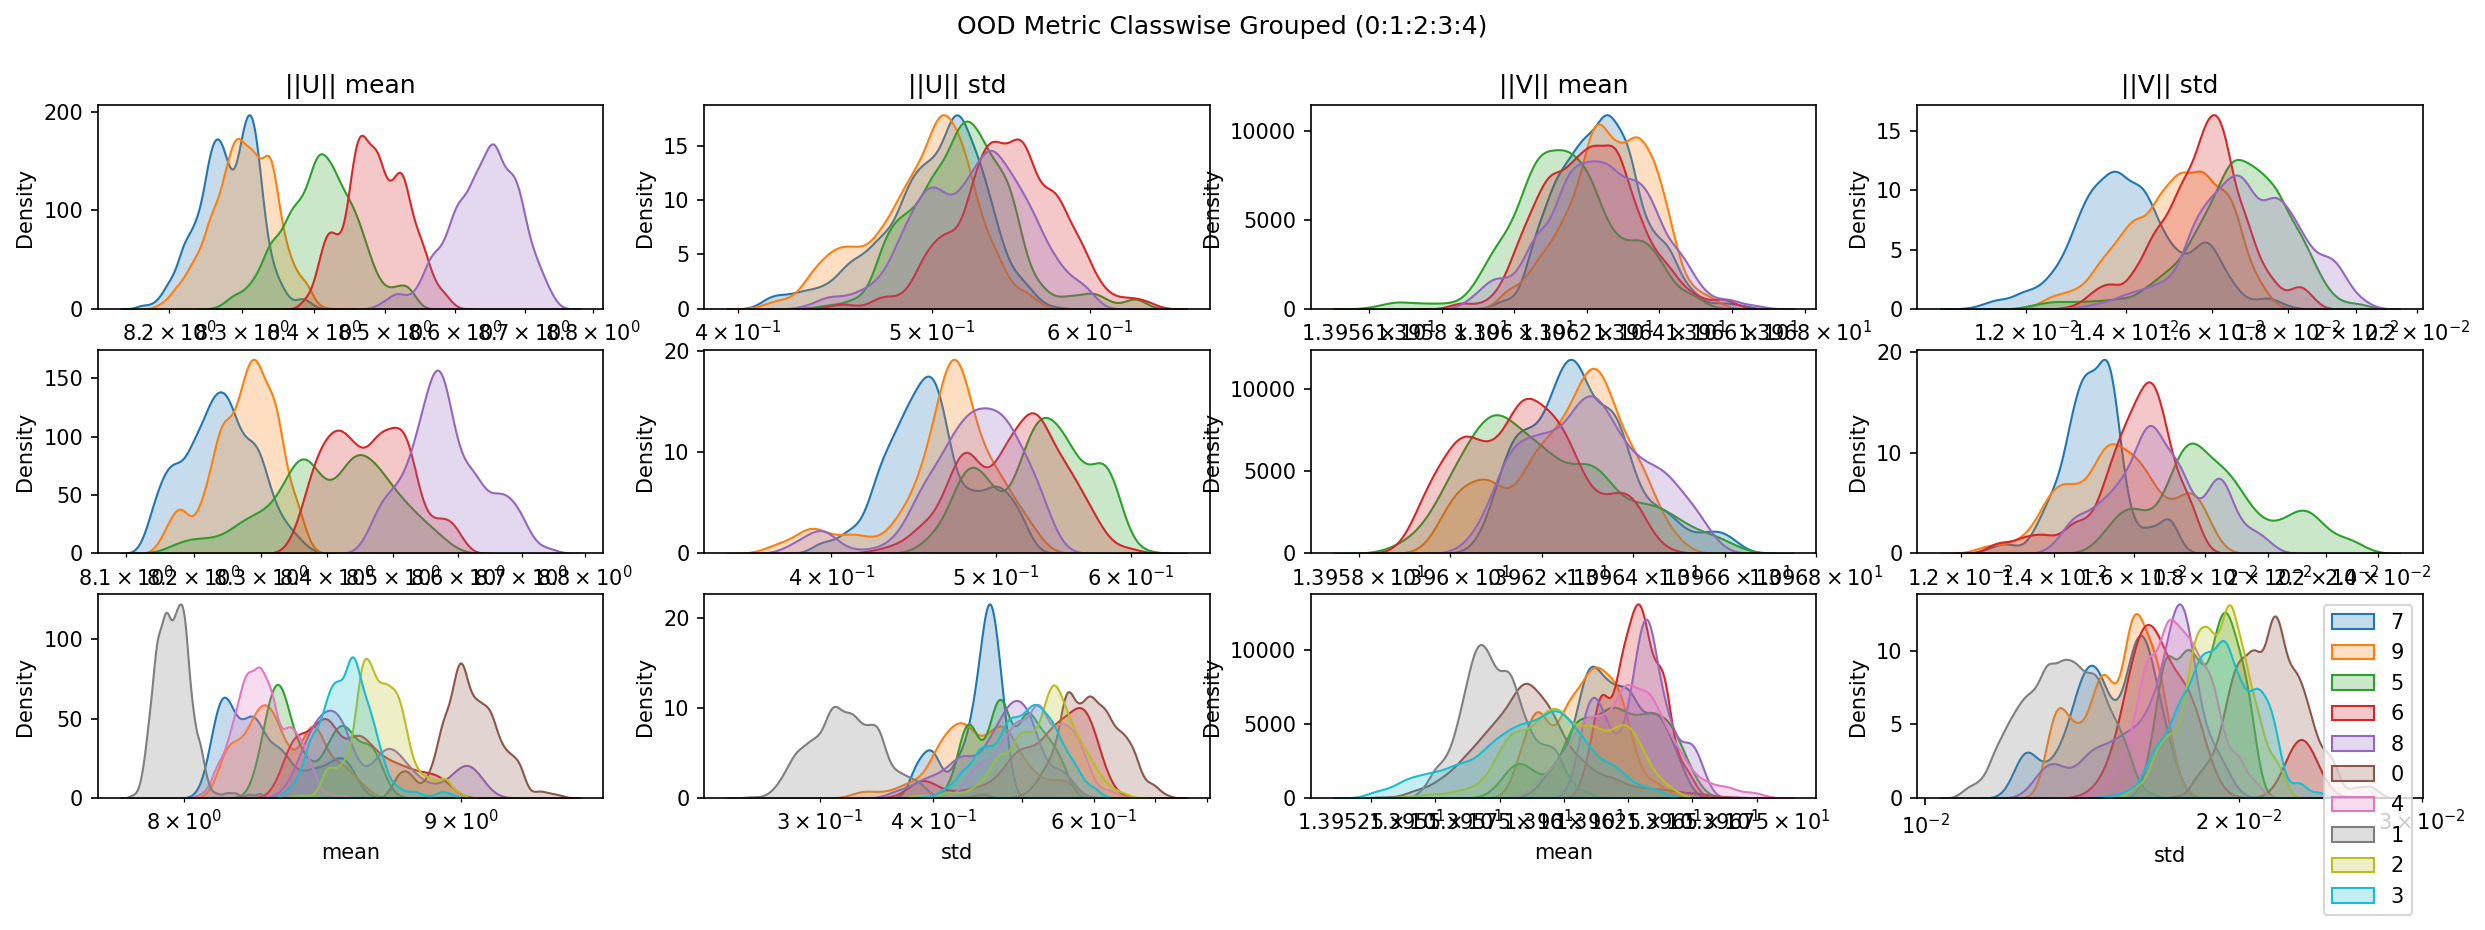

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())
print(all_targets)

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)